### Mounting Google Drive
We mount Google Drive to access our dataset stored in Drive.  
This allows us to read and save files directly from Colab. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

We begin by importing all the necessary libraries for our **Facial Recognition Project**:

- **os, random** → for file and folder handling.
- **pandas, numpy** → for data manipulation and numerical operations.
- **matplotlib, seaborn** → for data visualization.
- **cv2 (OpenCV)** → for image processing and face detection.
- **PIL (Python Imaging Library)** → for additional image handling.
- **TensorFlow / Keras** → for building and training the CNN model.
  - `VGG16`, `ResNet50V2` → Pre-trained models for transfer learning.
  - `Sequential`, `Model`, and layers (`Conv2D`, `Dense`, etc.) → model building.
  - `ImageDataGenerator` → real-time image augmentation.
  - `optimizers`, `regularizers`, and callbacks like `EarlyStopping`, `ReduceLROnPlateau` → for performance optimization.
- **sklearn.metrics** → to evaluate model performance using Confusion Matrix, ROC curves, and AUC.
- **compute_class_weight** → for handling class imbalance.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tensorflow as tf
import zipfile
from PIL import Image


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

In [ ]:
drive_path = "/content/drive/MyDrive"
os.listdir(drive_path)

['Colab Notebooks',
 'Katdrive',
 'documents',
 '.ipynb_checkpoints',
 'gen ai resume ats95.pdf',
 'gen ai resume 1pdf (7).pdf',
 'gen ai resume 1pdf (6).pdf',
 'gen ai resume 1pdf (5).pdf',
 'gen ai resume 1pdf (4).pdf',
 'gen ai resume 1pdf (3).pdf',
 'gen ai resume 1pdf (2).pdf',
 'gen ai resume 1pdf (1).pdf',
 'gen ai resume 1pdf.pdf',
 'archive.zip',
 'gen ai resume 3 (2).pdf',
 'gen ai resume 3 (1).pdf',
 'gen ai resume 3.pdf']

In [ ]:
zip_file = "/content/drive/MyDrive/archive.zip"

In [ ]:
extract_folder = '/content/dataset'

In [ ]:
os.makedirs(extract_folder, exist_ok = True)

In [ ]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)

In [ ]:
print(os.listdir(extract_folder))

['train', 'test']


### Project Directory Setup

We begin by creating a well-structured directory to organize different model experiments for our **Facial Recognition (Emotion Classification) Project**.

- **Project Name:** `emotion_classifier`
- **Base Directory:** `/content/dataset`
- **Models Created:**
  - `Custom_CNN_From_Scratch` → A CNN built from scratch.
  - `Custom_CNN_From_Augmentation` → CNN trained with data augmentation.
  - `VGG16_Transfer_Learning` → Transfer learning using pre-trained VGG16.
  - `ResNet50_Transfer_Learning` → Transfer learning using pre-trained ResNet50.

This ensures all models are trained, tested, and saved in their own dedicated subfolders.
Example of created structure:



In [ ]:
import os

# list your models
model_name = {'Custom_CNN_From_Scratch',
              'Custom_CNN_From_Augmentation',
              'VGG16_Transfer_Learning',
              'ResNet50_Transfer_Learning'}

# project name
project_name = 'emotion_classifier'
# base directory
base_dir = '/content/dataset'
# create project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# create subdirectory for each model
for model in model_name:
    model_dir = os.path.join(project_dir, model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at {project_dir}')


Project directory structure created at /content/dataset/emotion_classifier


### Exploring the Training Dataset

We now explore our dataset to check the number of images available for each **emotion class**.

- The dataset directory is `/content/dataset/train`.
- We loop through each subfolder (representing an emotion).
- Count the number of images in each class and print the results.

This helps in:
- Understanding dataset balance.
- Detecting any class imbalance issues that might affect model performance.


In [ ]:
train_dir = '/content/dataset/train'
emotion_classes = os.listdir(train_dir)
class_counts = {}
# count images in each class
print("Emotion class counts for training:")
for emotion in emotion_classes:
    emotion_dir = os.path.join(train_dir, emotion)
    if os.path.isdir(emotion_dir):  # check if it’s a directory
        count = len(os.listdir(emotion_dir))
        class_counts[emotion] = count
        print(f"{emotion}: {count} images")

Emotion class counts for training:
surprise: 3171 images
disgust: 436 images
angry: 3995 images
sad: 4830 images
fear: 4097 images
neutral: 4965 images
happy: 7215 images


### Class Distribution Visualization

We plot a bar chart to visualize the number of images in each **emotion class**.

This allows us to:
- Quickly identify whether the dataset is balanced.
- Spot if some emotions have significantly more or fewer samples.

A balanced dataset helps improve model performance, while imbalanced datasets may require techniques such as:
- Data augmentation
- Class weights
- Oversampling/undersampling


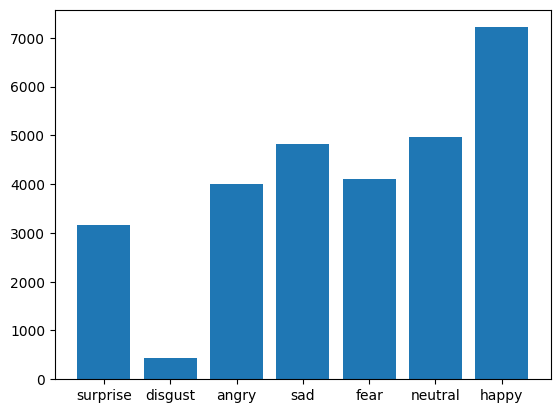

In [ ]:
plt.bar(class_counts.keys(), class_counts.values())
plt.show()

### Validation Dataset Exploration

Next, we check the distribution of images in the **validation dataset** (`/content/dataset/test`).

- We iterate over each class folder.
- Count the total number of images available for each emotion.
- Print the results to compare with training dataset distribution.

 Having similar class distribution in training and validation sets ensures the evaluation results are reliable.


In [ ]:
val_dir = '/content/dataset/test'
emotion_classes = os.listdir(val_dir)
val_class_counts = {}
# count images in each class
print("Emotion class counts for validation:")
for emotion in emotion_classes:
    emotion_dir = os.path.join(val_dir, emotion)
    if os.path.isdir(emotion_dir):  # check if it’s a directory
        count = len(os.listdir(emotion_dir))
        val_class_counts[emotion] = count
        print(f"{emotion}: {count} images")

Emotion class counts for validation:
surprise: 831 images
disgust: 111 images
angry: 958 images
sad: 1247 images
fear: 1024 images
neutral: 1233 images
happy: 1774 images


### Validation Dataset Distribution

The bar chart below shows the number of images available for each **emotion class** in the validation set.

From the results:
- **Happy** has the most images (1774).
- **Disgust** has the least images (111).
- Other classes like *sad*, *fear*, and *neutral* have around 1000–1200 samples.

 This indicates a **class imbalance problem**, which may cause the model to:
- Perform better on majority classes (e.g., Happy).
- Struggle with minority classes (e.g., Disgust).

 To address this, we may consider:
- **Data augmentation** for underrepresented classes.
- **Class weighting** during training.
- **Resampling techniques** if feasible.


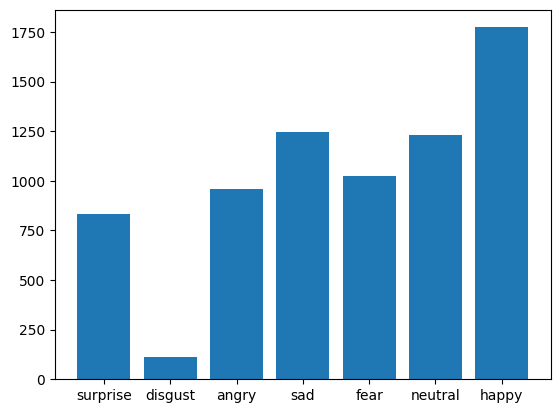

In [ ]:
plt.bar(val_class_counts.keys(), val_class_counts.values())
plt.show()

### Sample Training Images from Each Emotion Class

To better understand the dataset, we visualize one sample image from each **emotion class** in the training set.

This helps us:
- Verify that the dataset has been loaded correctly.
- Get an idea of the image quality and variation.
- Ensure the emotions are visually distinguishable.

Below is a grid showing example images for each emotion:


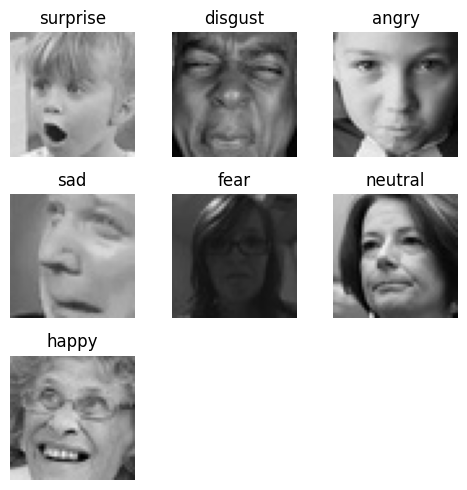

In [ ]:
emotions = os.listdir(train_dir)

plt.figure(figsize=(5, 5))

for i, emotion in enumerate(emotions, 1):
    img_list = os.listdir(os.path.join(train_dir, emotion))
    if len(img_list) > 42:  # make sure index 42 exists
        img_path = os.path.join(train_dir, emotion, img_list[42])
        img = cv2.imread(img_path)  # OpenCV reads in BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        ax = plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.title(emotion)
        plt.axis('off')

plt.tight_layout()
plt.show()

### Random Samples from a Specific Emotion Class

To further explore the dataset, we create a utility function that plots multiple random images from a selected **emotion class**.

- The function takes:
  - `directory_path` → Path to the class folder.
  - `class_name` → Emotion label (for titles).
  - `num_images` → Number of random images to display (default: 9).

- This allows us to visually inspect **intra-class variation** (differences within the same emotion), which is important for training a robust model.


In [ ]:
# plotting random images from the directory
def plot_image_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)
    if len(image_filenames) < num_images:
        num_images = len(image_filenames)

    random_images = random.sample(image_filenames, num_images)

    rows = cols = int(num_images**0.5) + 1  # calculate rows/cols dynamically
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(directory_path, img_name)
        img = image.load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    # hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Angry

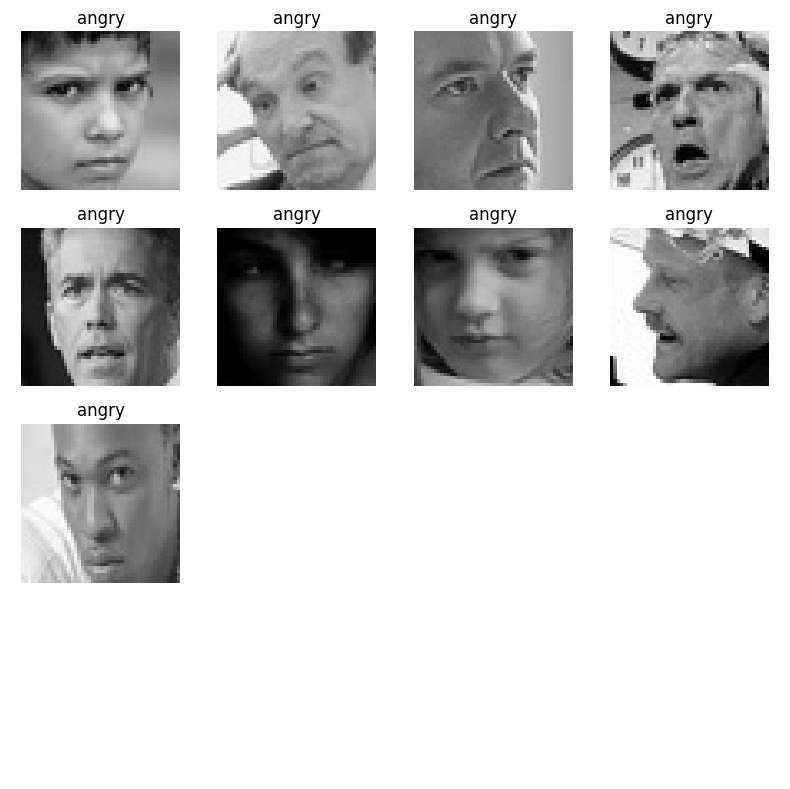

In [ ]:
angry_dir = '/content/dataset/train/angry'
plot_image_from_directory(angry_dir, 'angry')

### Disgust

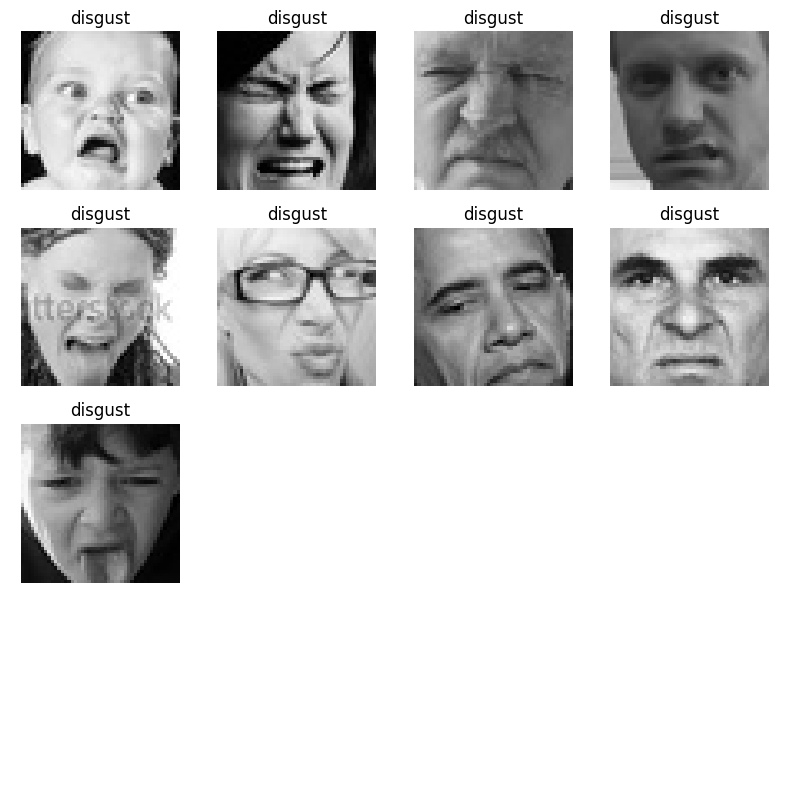

In [ ]:

disgust_dir = '/content/dataset/train/disgust'
plot_image_from_directory(disgust_dir, 'disgust')

### Fear

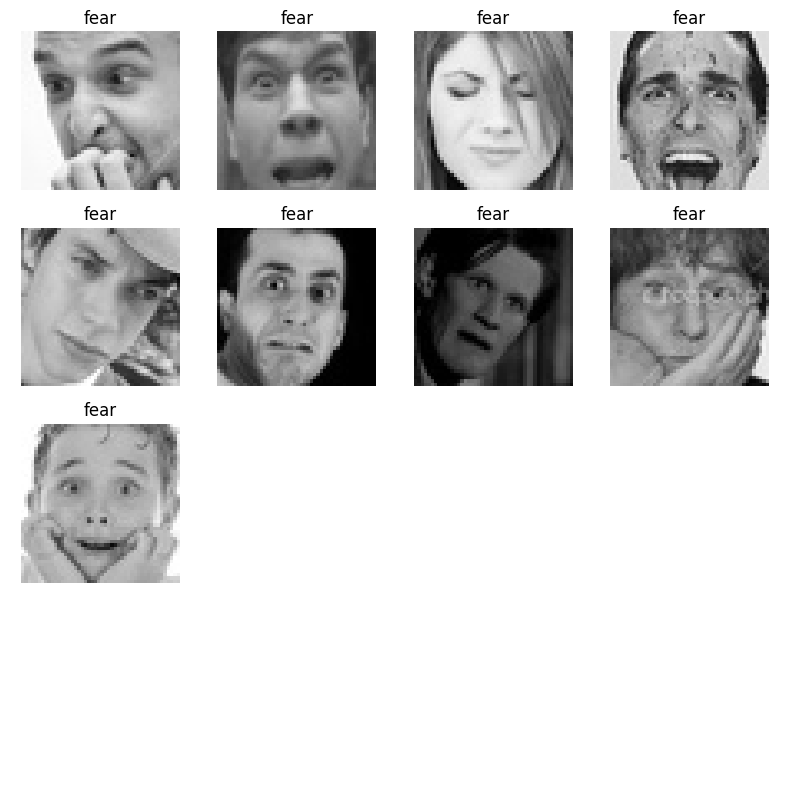

In [ ]:
fear_dir = '/content/dataset/train/fear'
plot_image_from_directory(fear_dir, 'fear')

### Happy

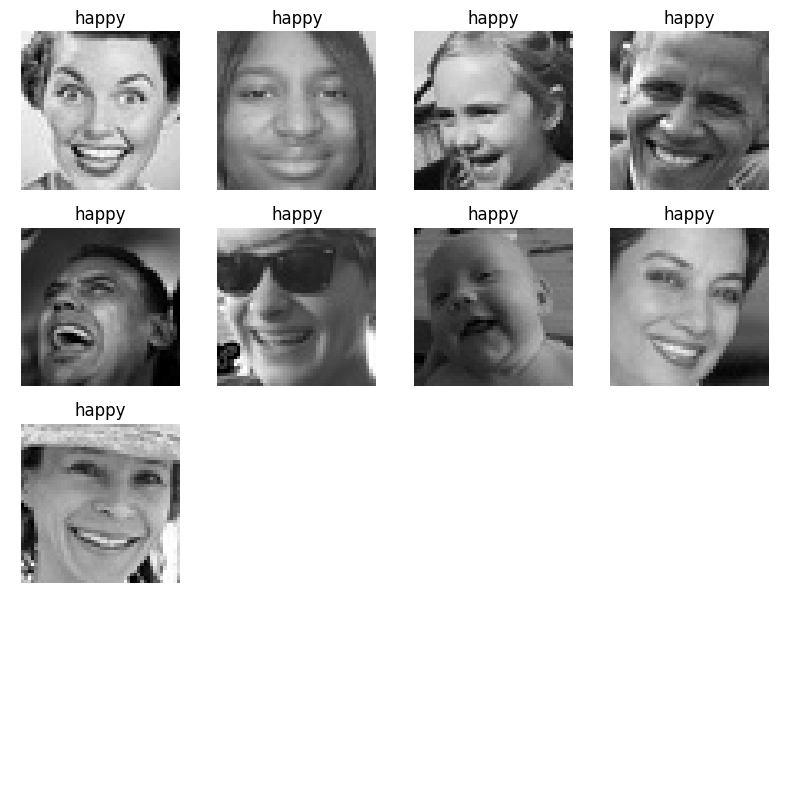

In [ ]:
happy_dir = '/content/dataset/train/happy'
plot_image_from_directory(happy_dir, 'happy')

### Neutral

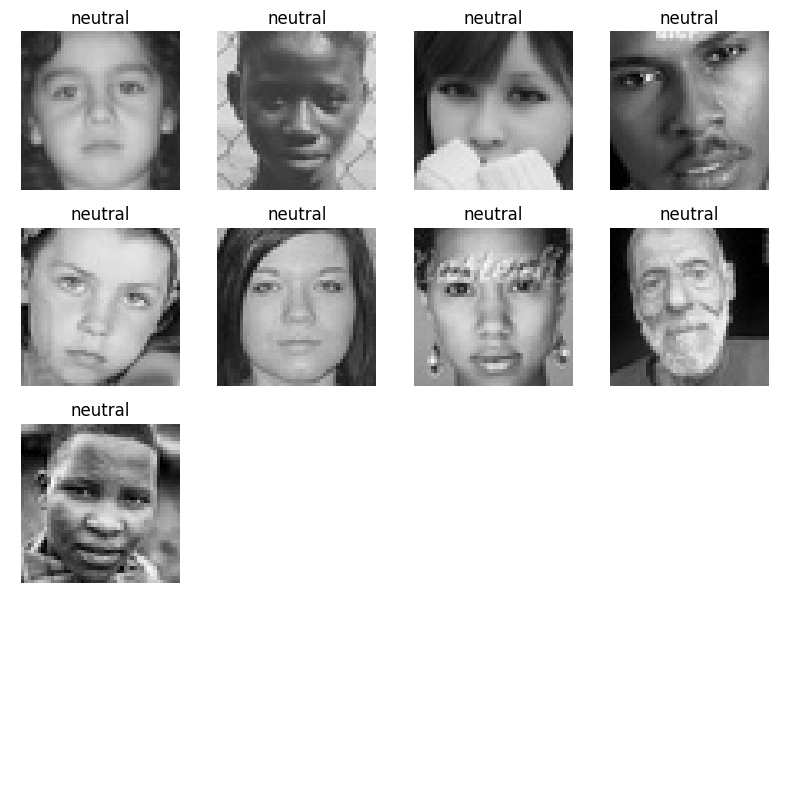

In [ ]:
neutral_dir = '/content/dataset/train/neutral'
plot_image_from_directory(neutral_dir, 'neutral')

### Sad

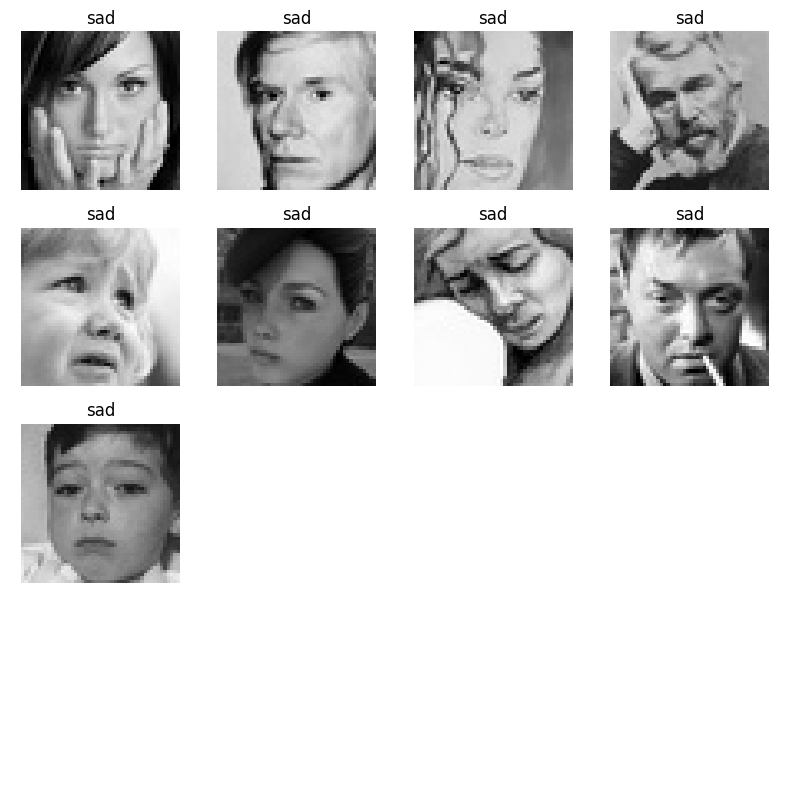

In [ ]:
sad_dir = '/content/dataset/train/sad'
plot_image_from_directory(sad_dir, 'sad')

### Surprise

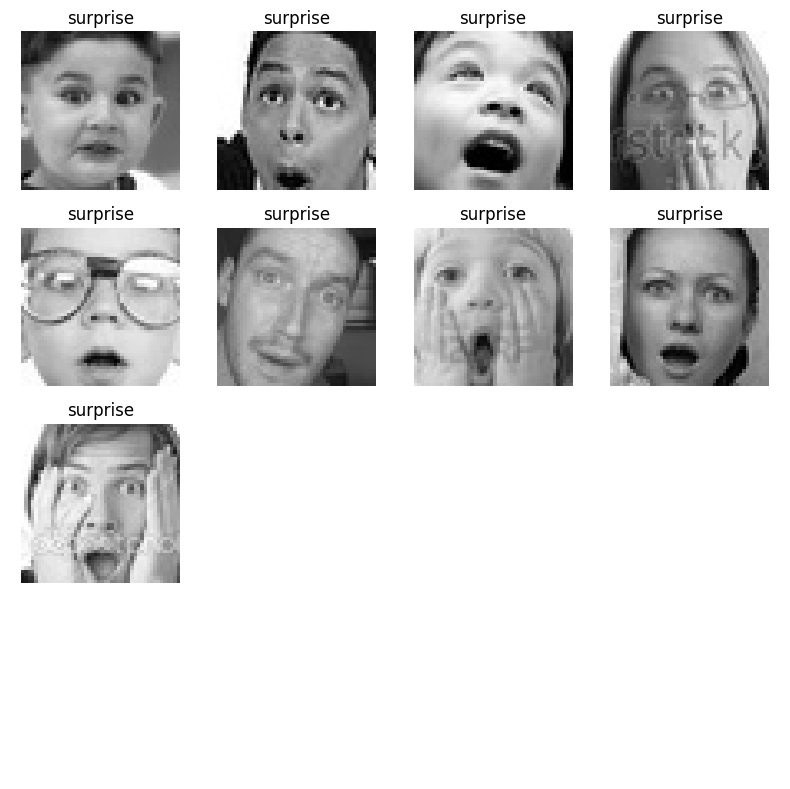

In [ ]:
surprise_dir = '/content/dataset/train/surprise'
plot_image_from_directory(surprise_dir, 'surprise')

### Verifying Image Loading

Before preprocessing and feeding images into the model, it's important to confirm that the dataset images can be successfully read.

In the snippet below:
- We load an image from the **test dataset** (`angry` class).
- Use OpenCV to read the image.
- Print its shape (Height × Width × Channels).
- If the image fails to load, we display an error message.

This ensures there are no issues with corrupt files or incorrect paths.


In [ ]:
image='/content/dataset/test/angry/PrivateTest_10131363.jpg'
img=cv2.imread(image)
if img is not None:
    print(img.shape)
else:
    print(f"Failed to load image from {image}")

(48, 48, 3)


### Loading Image in Grayscale

To reduce computational complexity and because facial expression features rely more on intensity patterns than colors,  
we load the image in **grayscale** instead of RGB.

- The shape `(48, 48)` indicates a single-channel grayscale image.
- This preprocessing step helps the model focus on facial features like eyes, mouth, and eyebrows.


In [ ]:
image='/content/dataset/test/angry/PrivateTest_10131363.jpg'
img=cv2.imread(image, cv2.IMREAD_GRAYSCALE)
if img is not None:
    print(img.shape)
else:
    print(f"Failed to load image from {image}")

(48, 48)


### Defining Dataset Paths

We specify the directories for training and testing data:

- `train_data_dir` → Contains labeled facial expression images for training the model.  
- `test_data_dir` → Contains separate images used for evaluating the model’s performance.  

This ensures a clear separation between the training and testing phases, preventing data leakage and providing an unbiased evaluation of the model.


In [ ]:
train_data_dir = '/content/dataset/train'
test_data_dir = '/content/dataset/test'

### Setting Hyperparameters

- **Image Dimensions:** `48 x 48`  
  Each image is resized to 48x48 pixels in grayscale, which is standard for emotion recognition datasets like FER-2013.  
- **Batch Size:** `64`  
  The number of images processed together before updating the model weights.  
- **Epochs:** `10`  
  The number of complete passes through the training dataset.  
- **Number of Classes:** `7`  
  The dataset contains 7 emotion categories: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.  


In [ ]:
img_width, img_height = 48,48
batch_size = 64
epochs=10
num_classes = 7

### Data Preprocessing with ImageDataGenerator

We normalize pixel values to the range `[0,1]` and generate batches of image data for training, validation, and testing.

- **Rescaling:** Divides pixel values by 255 for faster convergence.
- **Training Set:** Uses 80% of the training data (`subset='training'`).
- **Validation Set:** Uses 20% of the training data (`subset='validation'`).
- **Test Set:** Loaded separately to evaluate final performance.
- **Color Mode:** Grayscale (`1 channel`) since the dataset consists of grayscale images.
- **Target Size:** Images resized to `48 x 48`.

This ensures the model receives consistent input for both training and evaluation.


In [ ]:
# rescale the pixel values to [0,1]
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Class Labels Mapping

To interpret predictions correctly, we retrieve the mapping of class labels to their numeric indices for **training, validation, and testing** sets:

- `train_generator.class_indices`  
- `validation_generator.class_indices`  
- `test_generator.class_indices`  

This outputs a dictionary, for example:
python
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# accessing the class lablel for the training data
train_class_labels=train_generator.class_indices
print('train class labels',train_class_labels)

validation_class_labels=validation_generator.class_indices
print('validation class labels',validation_class_labels)

test_class_labels=test_generator.class_indices
print('test class labels',test_class_labels)

train class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
validation class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
test class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


### Model Architecture: Custom CNN for Emotion Recognition

We designed a deep Convolutional Neural Network (CNN) from scratch to classify facial expressions into 7 categories.

**Architecture Details**:
- **Input Layer:** 48×48 grayscale images  
- **Convolutional Blocks:**
  - Conv2D layers with increasing filters: 32 → 64 → 128 → 256 → 512  
  - ReLU activation functions  
  - Batch Normalization for stable training  
  - MaxPooling to reduce spatial dimensions  
  - Dropout layers to prevent overfitting
- **Fully Connected Layers:**
  - Dense layer with 1024 units (ReLU activation)  
  - Dropout (50%)  
- **Output Layer:**  
  - Dense layer with 7 units (Softmax activation)  
  - Each unit corresponds to one of the emotion classes: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise  

This CNN is designed to progressively learn complex facial features while reducing overfitting using regularization and dropout.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='glorot_uniform',padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compilation

The model is compiled with the following settings:

- **Optimizer:** Adam with a learning rate of 0.0001  
  - Chosen for its adaptive learning rate and efficiency in handling sparse gradients.  
- **Loss Function:** Categorical Crossentropy  
  - Suitable for multi-class classification problems with one-hot encoded labels.  
- **Evaluation Metric:** Accuracy  
  - Measures the proportion of correctly classified emotions.  

This setup ensures that the CNN is optimized to correctly classify facial expressions into 7 emotion categories.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

### Model Architecture Summary

The CNN model for emotion classification is structured as follows:

- **Input Layer:** Grayscale facial images of size 48×48 pixels.  
- **Convolutional Layers:**  
  - Three convolutional blocks with filters increasing from **32 → 64 → 128 → 256 → 512**.  
  - Each block applies:
    - **Conv2D** layers with ReLU activation for feature extraction.  
    - **Batch Normalization** to stabilize and accelerate training.  
    - **MaxPooling2D** to reduce spatial dimensions and capture essential features.  
    - **Dropout** (25%) for regularization, reducing overfitting.  
- **Flatten Layer:** Converts feature maps into a 1D vector.  
- **Fully Connected Layer:**  
  - **Dense(1024, ReLU)** with Dropout (50%) to learn high-level representations.  
- **Output Layer:**  
  - **Dense(7, Softmax)** for multi-class classification of emotions: *angry, disgust, fear, happy, neutral, sad, surprise*.  

**Model Size:**  
- **Total Parameters:** 22,813,703 (~87 MB)  
- **Trainable Parameters:** 22,812,039  
- **Non-Trainable Parameters:** 1,664  

This architecture balances depth and regularization, making it capable of capturing subtle facial features while reducing overfitting.


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

###  Model Save Path

We define the path where the trained CNN model will be stored for later use:

- **Base Directory:** `/content/dataset/emotion_classifier/Custom_CNN_From_Scratch`
- **Model Filename:** `custom_CNN_model.keras`


In [ ]:
cnn_path = '/content/dataset/emotion_classifier/Custom_CNN_From_Scratch'
name = 'custom_CNN_model.keras'
check_path = os.path.join(cnn_path, name)
check_path

'/content/dataset/emotion_classifier/Custom_CNN_From_Scratch/custom_CNN_model.keras'

###  Callbacks Setup

To optimize training and avoid overfitting, we use several callbacks:

1. **ModelCheckpoint**  
   - Saves the best version of the model (based on lowest validation loss).  
   - File saved at: `custom_CNN_model.keras`.

2. **EarlyStopping**  
   - Stops training if validation loss does not improve for 3 consecutive epochs.  
   - Restores the best weights to avoid overfitting.

3. **ReduceLROnPlateau**  
   - Reduces the learning rate by a factor of 0.2 if the validation loss plateaus for 6 epochs.  
   - Prevents getting stuck in local minima.

4. **CSVLogger**  
   - Logs training metrics (loss and accuracy per epoch) into a `.log` file for later analysis.

The callbacks are combined as:

python
callbacks = [checkpoint, early_stopped, reduce_lr, csv_logger]


In [ ]:
checkpoint = ModelCheckpoint(check_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early_stopped = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, early_stopped, reduce_lr, csv_logger]

###  Steps per Epoch Calculation

- **Why we calculate steps per epoch?**  
  Since we are using `ImageDataGenerator` with `flow_from_directory`, the data is loaded in batches.  
  We need to specify how many batches (steps) make up one epoch.

Dataset Statistics:

Training Samples: 22,968

Validation Samples: 5,741

Testing Samples: 7,178

Calculated Steps:

Training Steps/Epoch = train_generator.samples // batch_size + 1

Validation Steps/Epoch = validation_generator.samples // batch_size + 1

Test Steps/Epoch = test_generator.samples // batch_size + 1

In [ ]:
# calculating steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size+1
validation_steps = validation_generator.samples // validation_generator.batch_size+1
test_steps_epoch = test_generator.samples // test_generator.batch_size+1

In [ ]:
print(train_generator.samples)
print(validation_generator.samples)
print(test_generator.samples)

22968
5741
7178


In [ ]:
print(train_steps_per_epoch)
print(validation_steps)
print(test_steps_epoch)

359
90
113


In [ ]:
print(train_generator.batch_size+1)

65


###  Model Training

We trained our **Custom CNN model** for facial emotion recognition using the prepared training and validation datasets.

- **Training Parameters:**
  - Epochs: **10**
  - Batch Size: **64**
  - Optimizer: **Adam** (learning rate = 0.0001)
  - Loss Function: **Categorical Crossentropy**
  - Metrics: **Accuracy**

- **Callbacks Used:**
  - **ModelCheckpoint:** Saves the best model based on lowest validation loss.
  - **EarlyStopping:** Stops training early if validation loss doesn’t improve for 3 epochs.
  - **ReduceLROnPlateau:** Reduces the learning rate when validation loss stagnates.
  - **CSVLogger:** Logs training details into a CSV file for further analysis.

This ensures efficient training, prevents overfitting, and saves the best performing model.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2422 - loss: 13.4014
Epoch 1: val_loss improved from inf to 13.89551, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Scratch/custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - accuracy: 0.2423 - loss: 13.3986 - val_accuracy: 0.1754 - val_loss: 13.8955 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3186 - loss: 10.5423
Epoch 2: val_loss improved from 13.89551 to 9.54249, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Scratch/custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.3187 - loss: 10.5407 - val_accuracy: 0.3696 - val_loss: 9.5425 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3757 - loss: 8.3014
Epoch 3: val_loss improved from 9.54249 to 6.97017, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Scratch/custom_CNN_model.keras

###  Training & Validation Performance

The plots below illustrate the **training and validation accuracy and loss** over epochs.

- **Accuracy Curve:**  
  Shows how well the model improves in correctly classifying emotions across epochs.  
  The validation accuracy trend helps check if the model generalizes well.

- **Loss Curve:**  
  Tracks the model’s error during training and validation.  
  A decreasing loss indicates the model is learning effectively.

Ideally, the **training and validation accuracy should converge** while both losses decrease.  
A large gap would indicate **overfitting**.


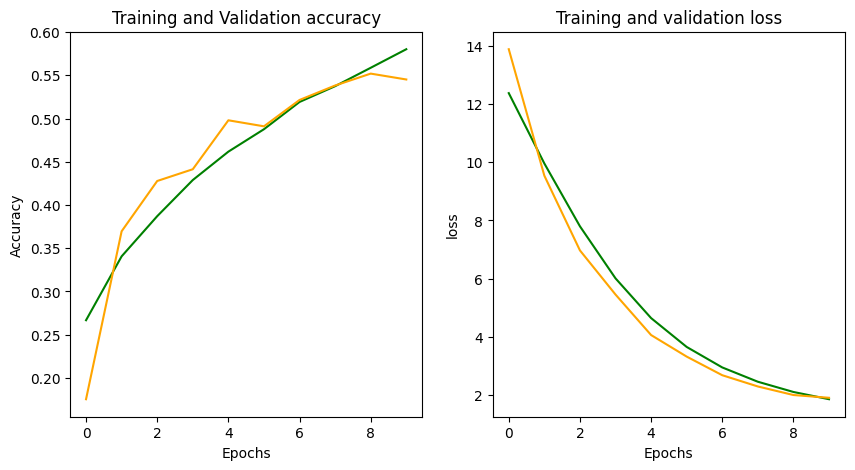

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color='orange')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss', color = 'green')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'orange')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

###  Model Evaluation Results

- **Training Accuracy:** 62.7%  
- **Training Loss:** 1.6452  
- **Test Accuracy:** 56.3%  
- **Test Loss:** 1.8625  

 **Observation:**  
The model shows reasonable learning capability with ~62% training accuracy and ~56% test accuracy.  
However, the gap between training and test performance suggests **room for improvement**, possibly by:

- Increasing the number of epochs or tuning hyperparameters  
- Using advanced architectures (e.g., VGG16, ResNet50) with transfer learning  
- Applying data augmentation to balance the classes  
- Fine-tuning learning rate or optimizer  

Overall, the baseline CNN captures meaningful emotion features but further optimization is required for higher accuracy.


In [ ]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)


359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.6270 - loss: 1.6452
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5630 - loss: 1.8625


###  Confusion Matrix Analysis

The confusion matrix above shows the distribution of predictions across the **7 emotion classes** on the test set.  

- Diagonal values represent the correctly classified samples.  
- Off-diagonal values show misclassifications between emotions.  
- We can identify which emotions are being confused most often. For example:
  - *Angry* may often be confused with *Sad*.
  - *Fear* and *Surprise* might overlap due to similar facial cues.  
  - *Neutral* and *Sad* could also show higher confusion.

 **Next Step:** A deeper evaluation using a **classification report (precision, recall, F1-score)** can provide a more detailed view of model performance for each class.


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


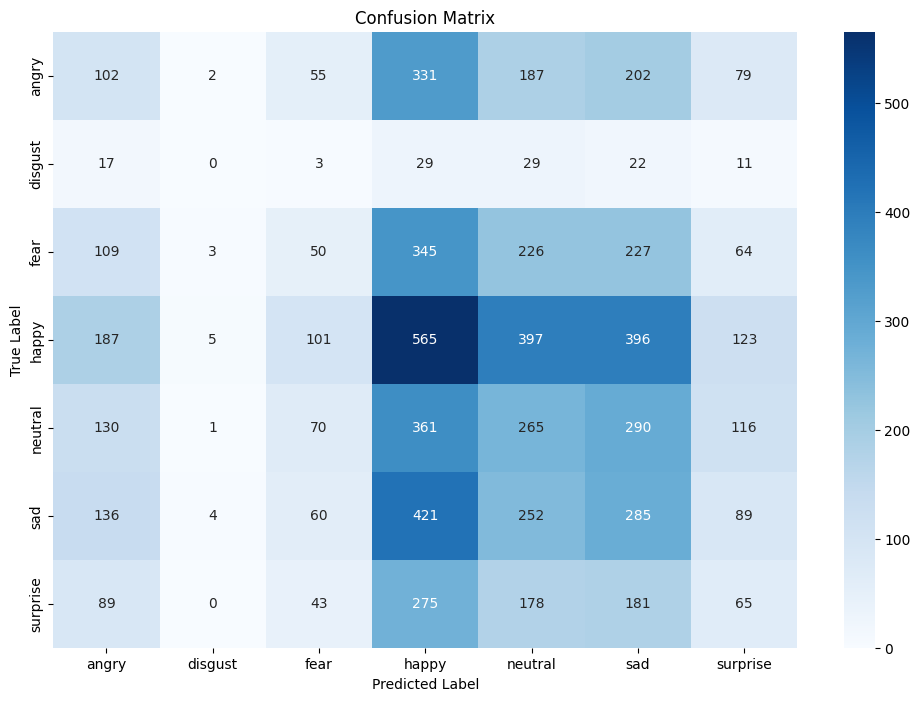

In [ ]:
# plotting confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Classification Report Analysis

The classification report provides deeper insights into the model’s performance:

- **Accuracy:** 19% overall, indicating the model struggles to generalize well on unseen test data.
- **Class-wise Performance:**
  - *Happy* achieved the best recall (32%) among all classes, but still relatively low.
  - *Angry, Fear, and Surprise* show very poor recall (<10%), meaning the model misses most samples of these classes.
  - *Disgust* is not recognized at all, with zero precision and recall.
- **Macro Average (14%)** shows that performance is low across all classes, without favoring one.
- **Weighted Average (17%)** indicates overall poor performance, especially for underrepresented classes.

 **Key Takeaway:**  
While the model captures some emotions like *Happy* and *Sad* to a degree, it performs poorly on others. Improvements may include:
- Increasing training epochs.
- Applying advanced data augmentation.
- Using transfer learning with pretrained models like **VGG16 or ResNet50**.
- Balancing classes (e.g., via class weights).


In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.05      0.07      1024
       happy       0.24      0.32      0.28      1774
     neutral       0.17      0.21      0.19      1233
         sad       0.18      0.23      0.20      1247
    surprise       0.12      0.08      0.09       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.19      0.17      7178



###  Random Predictions Visualization

This block randomly selects **10 images** from the test set and compares their **true labels** with the model’s predictions:

-  Correct predictions are shown in **green titles**.  
-  Incorrect predictions are shown in **red titles**.  
- Images are displayed in grayscale (48×48 resolution).  

This helps us **visually evaluate** the model’s strengths and weaknesses across different emotions.


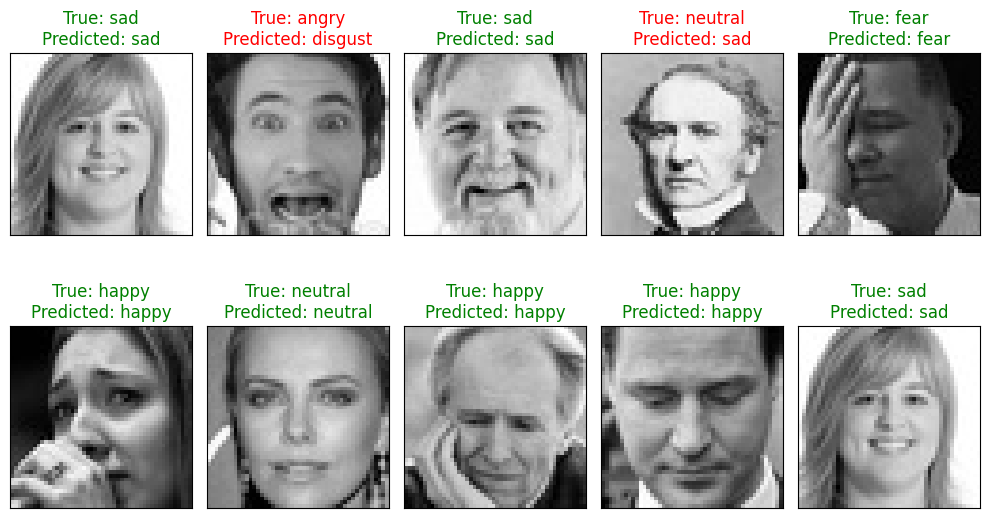

In [ ]:
batch_size = test_generator.batch_size

# pick a random batch
random_batch = np.random.randint(0, len(test_generator) - 1)

# pick 10 random images from the batch
random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # fetch random image and label
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]])

    # make prediction
    model_prediction = np.argmax(
        model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1
    )[0]

    # display image
    ax.imshow(random_img, cmap='grey')

    # set title with color coding
    color = 'green' if emotion_classes[random_img_label] == emotion_classes[model_prediction] else 'red'
    ax.set_title(f"True: {emotion_classes[random_img_label]}\nPredicted: {emotion_classes[model_prediction]}", color=color)

plt.tight_layout()
plt.show()


# model 2. Image Augmentation

In [ ]:
train_data_dir = '/content/dataset/train'
test_data_dir = '/content/dataset/test'

img_width, img_height = 48,48
batch_size = 64
epochs = 10
num_classes =7

data_generator = ImageDataGenerator(
    rescale =1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


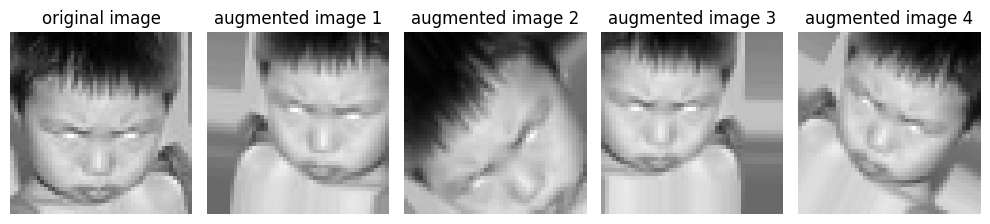

In [ ]:
img_path = '/content/dataset/train/angry/Training_10118481.jpg'
img = load_img(img_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255.0

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 6))
axes[0].imshow(img_array[0, :,:, 0], cmap='gray')
axes[0].set_title('original image')
axes[0].axis('off')

for i, ax in enumerate(axes.flat[1:]):
  # generate batch of augmented images
  aug_iter = data_generator.flow(img_array, batch_size=1)
  aug_img = next(aug_iter)[0]

# plot the augmented image
  ax.imshow(aug_img[:,:, 0], cmap='gray')
  ax.set_title(f'augmented image {i+1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

### Same CNN Model as above

In [ ]:
img_width, img_height = 48,48
num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size =(3,3), padding = 'same', input_shape = (img_width, img_height,1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size =(3,3), padding = 'same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size =(3,3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size =(3,3), kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size =(3,3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size =(3,3), kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
cnn_path = '/content/dataset/emotion_classifier/Custom_CNN_From_Augmentation'
name = 'custom_CNN_augmented_model.keras'
check_path = os.path.join(cnn_path, name)
check_path

checkpoint = ModelCheckpoint(check_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early_stopped = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, early_stopped, reduce_lr, csv_logger]

In [ ]:
# calculating steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size+1
validation_steps = validation_generator.samples // validation_generator.batch_size+1
test_steps_epoch = test_generator.samples // test_generator.batch_size+1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1966 - loss: 8.5864
Epoch 1: val_loss improved from inf to 7.62572, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Augmentation/custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 99ms/step - accuracy: 0.1967 - loss: 8.5847 - val_accuracy: 0.1134 - val_loss: 7.6257 - learning_rate: 1.0000e-04
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2389 - loss: 7.1495
Epoch 2: val_loss improved from 7.62572 to 6.72883, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Augmentation/custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 70ms/step - accuracy: 0.2389 - loss: 7.1491 - val_accuracy: 0.2574 - val_loss: 6.7288 - learning_rate: 1.0000e-04
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2366 - loss: 6.4826
Epoch 3: val_loss improved from 6.72883 to 6.05508, saving model to /content/dataset/emotion_classifier/Custom_CNN_From_Augmenta

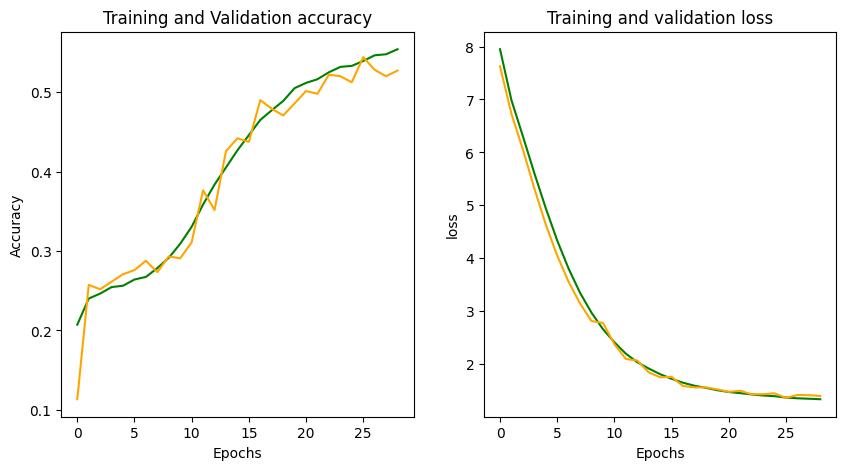

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color='orange')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss', color = 'green')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'orange')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.5533 - loss: 1.3268
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5492 - loss: 1.3672


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5591 - loss: 1.3285
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5498 - loss: 1.3506
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


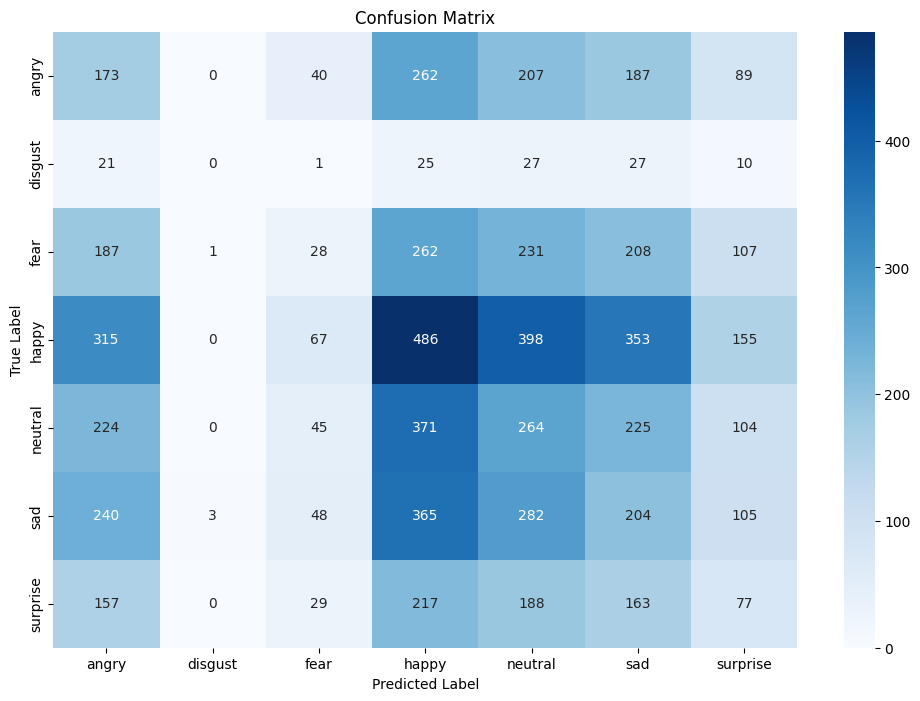

In [ ]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
# plotting confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.13      0.18      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.11      0.03      0.04      1024
       happy       0.24      0.27      0.26      1774
     neutral       0.17      0.21      0.19      1233
         sad       0.15      0.16      0.16      1247
    surprise       0.12      0.09      0.10       831

    accuracy                           0.17      7178
   macro avg       0.13      0.14      0.13      7178
weighted avg       0.16      0.17      0.16      7178



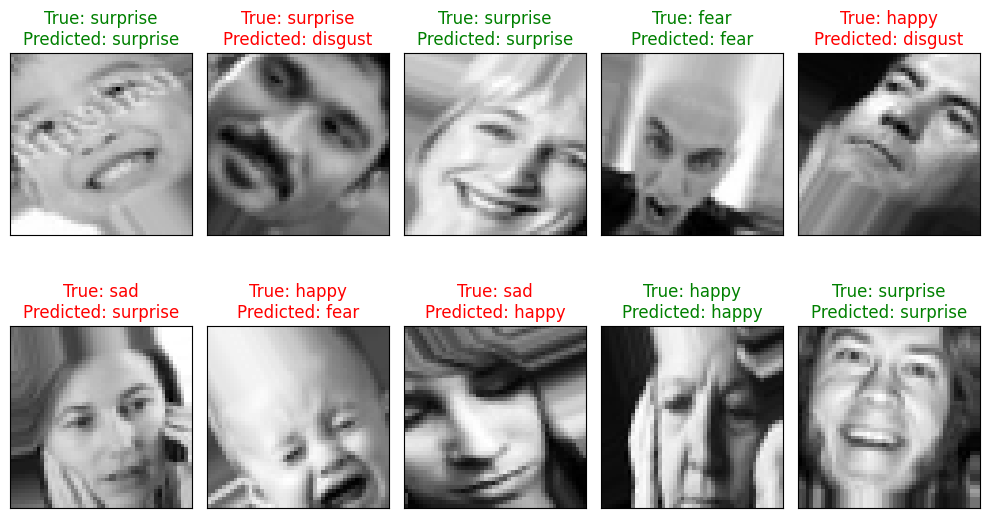

In [ ]:
batch_size = test_generator.batch_size

# pick a random batch
random_batch = np.random.randint(0, len(test_generator) - 1)

# pick 10 random images from the batch
random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # fetch random image and label
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]])

    # make prediction
    model_prediction = np.argmax(
        model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1
    )[0]

    # display image
    ax.imshow(random_img, cmap='grey')

    # set title with color coding
    color = 'green' if emotion_classes[random_img_label] == emotion_classes[model_prediction] else 'red'
    ax.set_title(f"True: {emotion_classes[random_img_label]}\nPredicted: {emotion_classes[model_prediction]}", color=color)

plt.tight_layout()
plt.show()


# Model 3. Transfer learning VGGNET

In [ ]:
train_data_dir = '/content/dataset/train'
test_data_dir = '/content/dataset/test'

img_width, img_height = 48,48
batch_size = 64
epochs = 10
num_classes =7

data_generator = ImageDataGenerator(
    rescale =1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

# validation_generator = data_generator.flow_from_directory(
#     train_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',
#     subset='validation'
# )

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = 7
tf.keras.backend.clear_session()

# load the vgg16 base model excluding top fully connected layers
vgg = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layers in vgg.layers[:-3]:
  layers.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
x = Flatten()(vgg.output)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=vgg.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'],
              )


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,412,999 (154.16 MB)

 Trainable params: 30,417,927 (116.04 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
cnn_path = '/content/dataset/emotion_classifier/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
check_path = os.path.join(cnn_path, name)
check_path

checkpoint = ModelCheckpoint(check_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early_stopped = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              min_delta=0,
                              restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, early_stopped, reduce_lr, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=5,
                    callbacks = callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.3578 - loss: 1.6505
Epoch 1: val_loss improved from inf to 1.30496, saving model to /content/dataset/emotion_classifier/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.3580 - loss: 1.6501 - val_accuracy: 0.4982 - val_loss: 1.3050 - learning_rate: 1.0000e-04
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.5041 - loss: 1.3094
Epoch 2: val_loss improved from 1.30496 to 1.21150, saving model to /content/dataset/emotion_classifier/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.5041 - loss: 1.3094 - val_accuracy: 0.5375 - val_loss: 1.2115 - learning_rate: 1.0000e-04
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.5425 - loss: 1.2091
Epoch 3: val_loss improved from 1.21150 to 1.17507, saving model to /content/dataset/emotion_classifier/VGG16_Transfer_Learning/VGG16_T

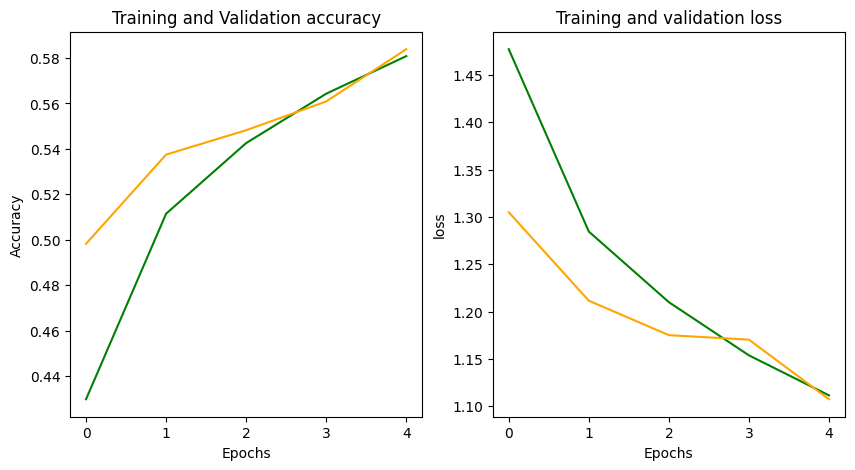

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color='orange')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss', color = 'green')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'orange')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)

449/449 ━━━━━━━━━━━━━━━━━━━━ 397s 884ms/step - accuracy: 0.6109 - loss: 1.0435
113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 890ms/step - accuracy: 0.5737 - loss: 1.1148


113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 868ms/step


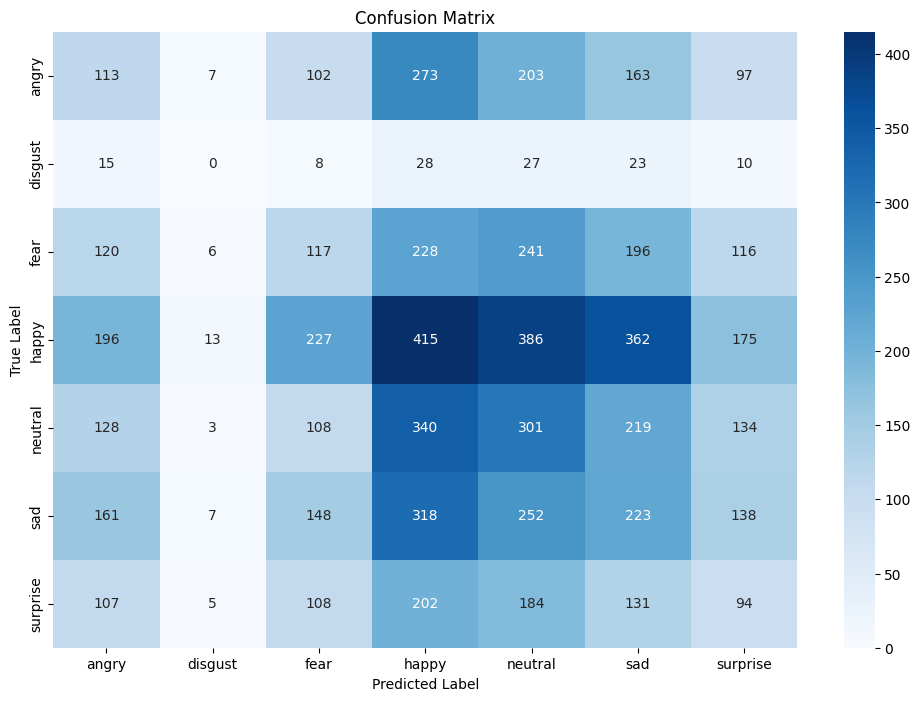

In [ ]:
# plotting confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.13      0.12      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.11      0.13      1024
       happy       0.23      0.23      0.23      1774
     neutral       0.19      0.24      0.21      1233
         sad       0.17      0.18      0.17      1247
    surprise       0.12      0.11      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



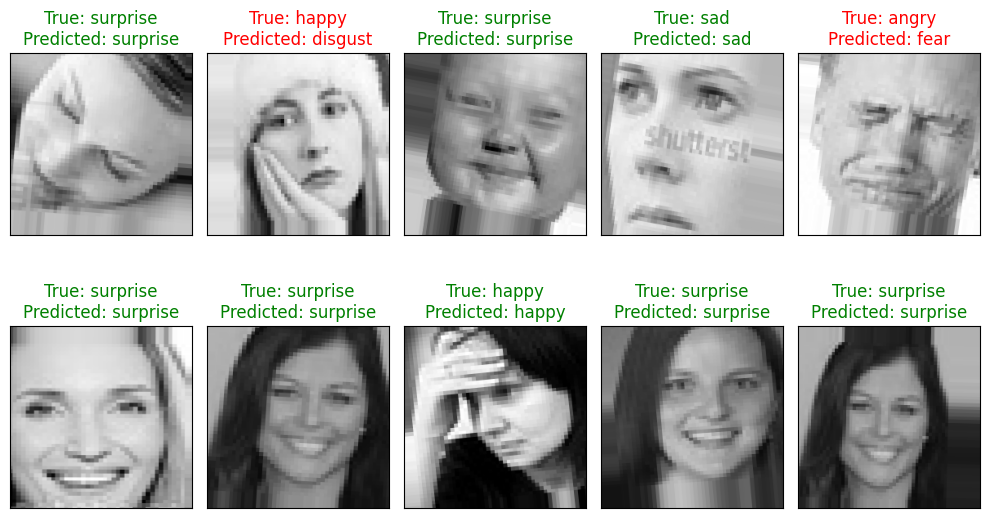

In [ ]:
batch_size = test_generator.batch_size

# pick a random batch
random_batch = np.random.randint(0, len(test_generator) - 1)

# pick 10 random images from the batch
random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # fetch random image and label
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]])

    # make prediction
    model_prediction = np.argmax(
        model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1
    )[0]

    # display image
    ax.imshow(random_img, cmap='grey')

    # set title with color coding
    color = 'green' if emotion_classes[random_img_label] == emotion_classes[model_prediction] else 'red'
    ax.set_title(f"True: {emotion_classes[random_img_label]}\nPredicted: {emotion_classes[model_prediction]}", color=color)

plt.tight_layout()
plt.show()


# Model 4. Transfer Learning Resnet50

In [ ]:
# Paths
train_data_dir = '/content/dataset/train'
test_data_dir = '/content/dataset/test'
cnn_path = '/content/dataset/emotion_classifier/ResNet50_Transfer_Learning'
os.makedirs(cnn_path, exist_ok=True)

# Image size and batch
img_width, img_height = 224, 224
batch_size = 32
num_classes = 7

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Class weights for imbalanced data
from sklearn.utils import class_weight

classes = np.array(train_generator.classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights:', class_weights_dict)

Class weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [ ]:
# Build the model
input_shape = (img_width, img_height, 3)
base_model = ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze base model
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile
optimizer = Adamax(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 1,218,311 (4.65 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(cnn_path, 'ResNet50_Transfer_Learning.keras'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopped = EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-4
)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, early_stopped, reduce_lr, csv_logger]

In [ ]:
# Training
train_steps = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,  # first train with frozen base
    validation_data=test_generator,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.2050 - loss: 1.9185
Epoch 1: val_loss improved from inf to 1.79346, saving model to /content/dataset/emotion_classifier/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 369s 392ms/step - accuracy: 0.2051 - loss: 1.9185 - val_accuracy: 0.3453 - val_loss: 1.7935 - learning_rate: 1.0000e-04
Epoch 2/10
  1/897 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.1562 - loss: 2.0117

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.79346 to 1.79336, saving model to /content/dataset/emotion_classifier/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.1562 - loss: 2.0117 - val_accuracy: 0.3449 - val_loss: 1.7934 - learning_rate: 1.0000e-04
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2869 - loss: 1.8074
Epoch 3: val_loss improved from 1.79336 to 1.69990, saving model to /content/dataset/emotion_classifier/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 341s 377ms/step - accuracy: 0.2870 - loss: 1.8074 - val_accuracy: 0.3710 - val_loss: 1.6999 - learning_rate: 1.0000e-04
Epoch 4/10
  1/897 ━━━━━━━━━━━━━━━━━━━━ 55s 62ms/step - accuracy: 0.2188 - loss: 1.4729
Epoch 4: val_loss improved from 1.69990 to 1.69950, saving model to /content/dataset/emotion_classifier/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 17s 19

In [ ]:
# Unfreeze base model for fine-tuning
base_model.trainable = True
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=1e-5),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [ ]:
# Fine-tune
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,  # fine-tune with lower lr
    validation_data=test_generator,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2496 - loss: 1.8902
Epoch 1: val_loss did not improve from 1.52084
897/897 ━━━━━━━━━━━━━━━━━━━━ 469s 464ms/step - accuracy: 0.2496 - loss: 1.8901 - val_accuracy: 0.3407 - val_loss: 1.6855 - learning_rate: 1.0000e-05
Epoch 2/20
  1/897 ━━━━━━━━━━━━━━━━━━━━ 3:40 246ms/step - accuracy: 0.2812 - loss: 1.3623
Epoch 2: val_loss did not improve from 1.52084
897/897 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.2812 - loss: 1.3623 - val_accuracy: 0.3403 - val_loss: 1.6851 - learning_rate: 1.0000e-05
Epoch 3/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2870 - loss: 1.7813
Epoch 3: val_loss did not improve from 1.52084
897/897 ━━━━━━━━━━━━━━━━━━━━ 389s 434ms/step - accuracy: 0.2870 - loss: 1.7813 - val_accuracy: 0.3830 - val_loss: 1.6121 - learning_rate: 1.0000e-05
Epoch 4/20
  1/897 ━━━━━━━━━━━━━━━━━━━━ 3:33 239ms/step - accuracy: 0.2812 - loss: 1.5625
Epoch 4: val_loss did not improve from 1.52084
897/897 ━━━

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color='orange')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss', color = 'green')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'orange')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)

In [ ]:

# plotting confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
    ),
    axis=1
)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
batch_size = test_generator.batch_size

# pick a random batch
random_batch = np.random.randint(0, len(test_generator) - 1)

# pick 10 random images from the batch
random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # fetch random image and label
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]])

    # make prediction
    model_prediction = np.argmax(
        model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1
    )[0]

    # display image
    ax.imshow(random_img, cmap='grey')

    # set title with color coding
    color = 'green' if emotion_classes[random_img_label] == emotion_classes[model_prediction] else 'red'
    ax.set_title(f"True: {emotion_classes[random_img_label]}\nPredicted: {emotion_classes[model_prediction]}", color=color)

plt.tight_layout()
plt.show()


# AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')